# 🎓 Введение

Привет, участники соревнования! 👋

Этот ноутбук — ваш проводник в мир анализа временных рядов и построения моделей машинного обучения. Он написан специально для тех, кто только начинает знакомство с Kaggle и участвует в соревнованиях впервые.

Здесь мы вместе:
- 📈 научимся извлекать признаки из временных рядов,
- 🧠 построим базовую модель машинного обучения (LightGBM),
- 🧪 проведём корректную валидацию,
- 📤 подготовим прогноз и отправим его в виде submission-файла.

> 💡 Несмотря на то, что текущее решение не побеждает бенчмарки, **совсем небольшие улучшения** (например, другие признаки, параметры модели или архитектура) уже позволят вам занять **топовые места** в рейтинге!

Цель этого ноутбука — **показать вам базовый, но правильный путь**:
- никаких "магических" трюков,
- только понятные и воспроизводимые шаги.

Удачи в соревновании! 🚀  
**Вы уже на правильном пути.**


In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import os

# 1. Загрузка
work_dir = "../input/kazakhstan-ai-respa-take-home/"
# work_dir = "../input/kazakhstan-ai-respa-take-home/"
train = pd.read_csv(os.path.join(work_dir, "train.csv"))
train['submitted_date'] = pd.to_datetime(train['submitted_date'])
train.head()

,category,submitted_date,num_papers
0,hep-ph - High Energy Physics - Phenomenology,2000-01-01,5
1,hep-ph - High Energy Physics - Phenomenology,2000-01-02,6
2,hep-ph - High Energy Physics - Phenomenology,2000-01-03,14
3,hep-ph - High Energy Physics - Phenomenology,2000-01-04,10
4,hep-ph - High Energy Physics - Phenomenology,2000-01-05,16


## 📂 Работа с одной категорией

Для начала сосредоточимся на одной подкатегории. Мы извлечём её временной ряд — упорядочим по дате, сделаем дату индексом и уберём лишние колонки. Это поможет нам удобно считать rolling-статистики и готовить признаки.


In [2]:
def get_category_data(df: pd.DataFrame, category: str):
    category_data = df[df['category'] == category].copy()
    category_data = category_data.sort_values('submitted_date')
    category_data = category_data.set_index('submitted_date')
    return category_data.drop('category', axis=1)

category_data = get_category_data(train, 'hep-ph - High Energy Physics - Phenomenology')
category_data

,num_papers
submitted_date,
2000-01-01,5
2000-01-02,6
2000-01-03,14
2000-01-04,10
2000-01-05,16
...,...
2025-02-05,32
2025-02-06,29
2025-02-07,25


<Axes: xlabel='submitted_date'>

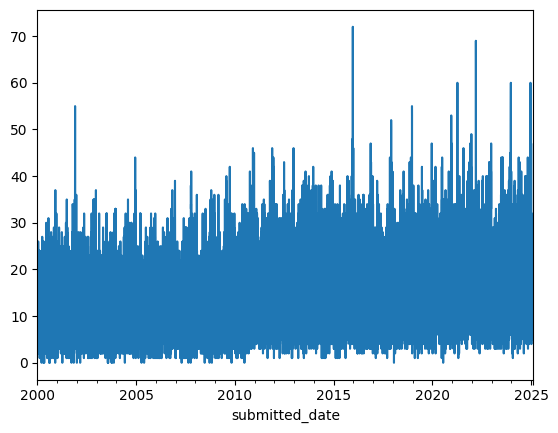

In [3]:
category_data.num_papers.plot()

## 🔮 Расширение данных на будущее

Чтобы наша модель могла делать прогнозы, мы расширим временной ряд на одну неделю вперёд.  

Мы добавим 7 будущих дат без значений — они нужны, чтобы модель могла "заглянуть в будущее" и сгенерировать признаки для предсказания тестовых данных.

Для простоты мы будем прогнозировать только одну следующую неделю - а дальше мы будем просто повторять наши прогнозы

In [4]:
def extend_dataset(category_data, last_train_date, future_weeks_num: int = 0):
    if future_weeks_num > 0:
        future_dates = pd.date_range(
                start=last_train_date + pd.Timedelta(days=1),
                periods=future_weeks_num * 7,
                freq='D'
            )
            
        future = pd.DataFrame(index= future_dates, data={'num_papers': None})
        return pd.concat((category_data, future))

last_train_date=train.submitted_date.max()
category_data = extend_dataset(category_data, last_train_date=last_train_date, future_weeks_num=8)

print(last_train_date)
category_data

2025-02-09 00:00:00


,num_papers
2000-01-01,5
2000-01-02,6
2000-01-03,14
2000-01-04,10
2000-01-05,16
...,...
2025-04-02,None
2025-04-03,None
2025-04-04,None
2025-04-05,None


In [5]:
category_data.tail(20)

,num_papers
2025-03-18,None
2025-03-19,None
2025-03-20,None
2025-03-21,None
2025-03-22,None
2025-03-23,None
2025-03-24,None
2025-03-25,None
2025-03-26,None
2025-03-27,None


## 📊 Расчёт rolling-признаков (скользящих аггрегаций)

Теперь посчитаем базовые признаки по скользящему окну (rolling window):

- `rolling_sum_during_week` — сколько статей было опубликовано за последние 7 дней.
- `rolling_max_during_week` — максимум статей этой категории в день за последние 7 дней.
- `rolling_min_during_month` и `rolling_max_during_month` — минимум и максимум за последние 28 дней (месяц).

Эти признаки помогут модели понимать недавнюю активность в категории.


In [6]:
def get_rolling_features(cat_data: pd.DataFrame):
    df = pd.DataFrame()
    
    idx = cat_data.index
    
    windows = {
        '3d':    3,
        '7d':    7,
        '14d':  14,
        '28d':  28,
        '90d':  90,
        '365d': 365,
    }

    for name, w in windows.items():
        rolling = cat_data['num_papers'].rolling(window=w, min_periods=1)
        df[f'roll_mean_{name}'] = rolling.mean()
        df[f'roll_std_{name}']  = rolling.std()
        df[f'roll_min_{name}']  = rolling.min()
        df[f'roll_max_{name}']  = rolling.max()
        df[f'roll_sum_{name}']  = rolling.sum()
        
        df[f'roll_skew_{name}'] = rolling.skew()
        if w >= 28:
            df[f'roll_q25_{name}'] = rolling.quantile(0.25)
            df[f'roll_q75_{name}'] = rolling.quantile(0.75)
    

    
    df['ewm_mean_7']  = cat_data['num_papers'].ewm(span=7,  min_periods=1).mean()
    df['ewm_std_7']   = cat_data['num_papers'].ewm(span=7,  min_periods=1).std()
    df['ewm_mean_28'] = cat_data['num_papers'].ewm(span=28, min_periods=1).mean()
    df['ewm_std_28']  = cat_data['num_papers'].ewm(span=28, min_periods=1).std()

    # df['diff_1']    = cat_data['num_papers'] - cat_data['num_papers'].shift(1)
    # df['rm7_rm28']  = df['roll_mean_7d'] - df['roll_mean_28d']
    # df['ratio_rm7'] = cat_data['num_papers'] / (df['roll_mean_7d'] + 1e-6)
    
    df['dayofweek']      = idx.dayofweek
    df['weekofyear']     = idx.isocalendar().week.astype(int)
    df['month']          = idx.month
    df['is_month_start'] = idx.is_month_start.astype(int)
    df['is_month_end']   = idx.is_month_end.astype(int)

    from scipy.stats import linregress
    slopes = []
    pd.set_option('future.no_silent_downcasting', True)
    vals = cat_data['num_papers'].fillna(0).astype(int).values


    for i in range(len(vals)):
        if i < 14:
            slopes.append(0.0)
        else:
            y = vals[i-14:i]
            x = np.arange(14)
            slopes.append(linregress(x, y).slope)
    df['slope_14d'] = slopes

    
    df.fillna(0, inplace=True)  # Replaces NaN with 0, you can choose another method
    
    return df

rolling_features = get_rolling_features(cat_data=category_data)
rolling_features

,roll_mean_3d,roll_std_3d,roll_min_3d,roll_max_3d,roll_sum_3d,roll_skew_3d,roll_mean_7d,roll_std_7d,roll_min_7d,roll_max_7d,...,ewm_mean_7,ewm_std_7,ewm_mean_28,ewm_std_28,dayofweek,weekofyear,month,is_month_start,is_month_end,slope_14d
2000-01-01,5.000000,0.000000,5.0,5.0,5.0,0.000000e+00,5.000000,0.000000,5.0,5.0,...,5.000000,0.000000,5.000000,0.000000,5,52,1,1,0,0.0
2000-01-02,5.500000,0.707107,5.0,6.0,11.0,0.000000e+00,5.500000,0.707107,5.0,6.0,...,5.571429,0.707107,5.517857,0.707107,6,52,1,0,0,0.0
2000-01-03,8.333333,4.932883,5.0,14.0,25.0,1.652317e+00,8.333333,4.932883,5.0,14.0,...,9.216216,5.205247,8.549511,5.006923,0,1,1,0,0,0.0
2000-01-04,10.000000,4.000000,6.0,14.0,30.0,-3.996803e-15,8.750000,4.112988,5.0,14.0,...,9.502857,3.946466,8.951877,4.083211,1,1,1,0,0,0.0
2000-01-05,13.333333,3.055050,10.0,16.0,40.0,-9.352195e-01,10.200000,4.816638,5.0,16.0,...,11.632522,4.688911,10.569796,4.801844,2,1,1,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-02,0.000000,0.000000,0.0,0.0,0.0,0.000000e+00,0.000000,0.000000,0.0,0.0,...,16.068222,11.443078,19.672847,9.855243,2,14,4,0,0,0.0
2025-04-03,0.000000,0.000000,0.0,0.0,0.0,0.000000e+00,0.000000,0.000000,0.0,0.0,...,16.068222,11.443078,19.672847,9.855243,3,14,4,0,0,0.0
2025-04-04,0.000000,0.000000,0.0,0.0,0.0,0.000000e+00,0.000000,0.000000,0.0,0.0,...,16.068222,11.443078,19.672847,9.855243,4,14,4,0,0,0.0
2025-04-05,0.000000,0.000000,0.0,0.0,0.0,0.000000e+00,0.000000,0.000000,0.0,0.0,...,16.068222,11.443078,19.672847,9.855243,5,14,4,0,0,0.0


In [7]:
rolling_features.tail(10)

,roll_mean_3d,roll_std_3d,roll_min_3d,roll_max_3d,roll_sum_3d,roll_skew_3d,roll_mean_7d,roll_std_7d,roll_min_7d,roll_max_7d,...,ewm_mean_7,ewm_std_7,ewm_mean_28,ewm_std_28,dayofweek,weekofyear,month,is_month_start,is_month_end,slope_14d
2025-03-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.068222,11.443078,19.672847,9.855243,4,13,3,0,0,0.0
2025-03-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.068222,11.443078,19.672847,9.855243,5,13,3,0,0,0.0
2025-03-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.068222,11.443078,19.672847,9.855243,6,13,3,0,0,0.0
2025-03-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.068222,11.443078,19.672847,9.855243,0,14,3,0,1,0.0
2025-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.068222,11.443078,19.672847,9.855243,1,14,4,1,0,0.0
2025-04-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.068222,11.443078,19.672847,9.855243,2,14,4,0,0,0.0
2025-04-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.068222,11.443078,19.672847,9.855243,3,14,4,0,0,0.0
2025-04-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.068222,11.443078,19.672847,9.855243,4,14,4,0,0,0.0
2025-04-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.068222,11.443078,19.672847,9.855243,5,14,4,0,0,0.0
2025-04-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.068222,11.443078,19.672847,9.855243,6,14,4,0,0,0.0


## ⏪ Добавление лагов (значений сдвига)

Теперь добавим **лаг-признаки** — значения, которые были ровно неделю назад:

- Например, `rolling_sum_during_week_last_week` — это сумма за неделю, но из **предыдущей** недели.
- Такие признаки важны, чтобы модель могла "вспоминать", что происходило ранее, и делать выводы на основе динамики.

Мы используем `.shift(freq='7D')`, чтобы сместить значения на 7 дней назад.

In [8]:
def add_lag_features(features: pd.DataFrame):
    new_features = features.copy()
    for col in features.columns:
        new_features[f'{col}_last_8weeks'] = features[col].shift(freq=pd.Timedelta(days=56))
    return new_features.dropna()

lag_features = add_lag_features(rolling_features)
lag_features

,roll_mean_3d,roll_std_3d,roll_min_3d,roll_max_3d,roll_sum_3d,roll_skew_3d,roll_mean_7d,roll_std_7d,roll_min_7d,roll_max_7d,...,ewm_mean_7_last_8weeks,ewm_std_7_last_8weeks,ewm_mean_28_last_8weeks,ewm_std_28_last_8weeks,dayofweek_last_8weeks,weekofyear_last_8weeks,month_last_8weeks,is_month_start_last_8weeks,is_month_end_last_8weeks,slope_14d_last_8weeks
2000-02-26,15.333333,9.814955,4.0,21.0,46.0,-1.732051,12.285714,7.476949,3.0,21.0,...,5.000000,0.000000,5.000000,0.000000,5.0,52.0,1.0,1.0,0.0,0.000000
2000-02-27,9.000000,10.440307,2.0,21.0,27.0,1.660818,12.142857,7.690439,2.0,21.0,...,5.571429,0.707107,5.517857,0.707107,6.0,52.0,1.0,0.0,0.0,0.000000
2000-02-28,6.000000,5.291503,2.0,12.0,18.0,1.457863,11.714286,7.587584,2.0,21.0,...,9.216216,5.205247,8.549511,5.006923,0.0,1.0,1.0,0.0,0.0,0.000000
2000-02-29,10.333333,7.637626,2.0,17.0,31.0,-0.935220,13.000000,7.615773,2.0,21.0,...,9.502857,3.946466,8.951877,4.083211,1.0,1.0,1.0,0.0,0.0,0.000000
2000-03-01,14.333333,2.516611,12.0,17.0,43.0,0.585583,13.000000,7.615773,2.0,21.0,...,11.632522,4.688911,10.569796,4.801844,2.0,1.0,1.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-02,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,22.302037,9.163646,21.066928,9.019375,2.0,6.0,2.0,0.0,0.0,-0.529670
2025-04-03,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,23.976527,8.531883,21.614036,8.940326,3.0,6.0,2.0,0.0,0.0,-0.127473
2025-04-04,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,24.232396,7.404317,21.847551,8.670667,4.0,6.0,2.0,0.0,0.0,0.182418
2025-04-05,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,19.424297,11.046732,20.685651,9.428455,5.0,6.0,2.0,0.0,0.0,0.586813


## 📆 Преобразование в недельный уровень

Поскольку нам нужно делать прогноз **по неделям**, агрегируем ежедневные признаки в недельные.

- Каждому дню мы сопоставим конец недели (воскресенье).
- Затем для каждой недели возьмём **последнее доступное значение** признаков.
- Это даст нам ровно одну строку признаков на каждую неделю.

Теперь мы готовы строить таргет и обучать модель.


In [9]:
def build_weekly_features(features):
    daily_features = features.reset_index(names="day")
    daily_features['week'] = daily_features['day'] + pd.to_timedelta(6 - daily_features['day'].dt.weekday, unit='D')
    weekly_features = daily_features.groupby('week').last().reset_index()
    return weekly_features.drop('day', axis=1)

weekly_features = build_weekly_features(lag_features)
weekly_features

,week,roll_mean_3d,roll_std_3d,roll_min_3d,roll_max_3d,roll_sum_3d,roll_skew_3d,roll_mean_7d,roll_std_7d,roll_min_7d,...,ewm_mean_7_last_8weeks,ewm_std_7_last_8weeks,ewm_mean_28_last_8weeks,ewm_std_28_last_8weeks,dayofweek_last_8weeks,weekofyear_last_8weeks,month_last_8weeks,is_month_start_last_8weeks,is_month_end_last_8weeks,slope_14d_last_8weeks
0,2000-02-27,9.000000,10.440307,2.0,21.0,27.0,1.660818,12.142857,7.690439,2.0,...,5.571429,0.707107,5.517857,0.707107,6.0,52.0,1.0,0.0,0.0,0.000000
1,2000-03-05,8.000000,8.717798,2.0,18.0,24.0,1.630059,10.714286,6.237368,2.0,...,7.161288,5.107507,8.413227,4.834514,6.0,1.0,1.0,0.0,0.0,0.000000
2,2000-03-12,8.333333,9.291573,2.0,19.0,25.0,1.642207,13.000000,7.483315,2.0,...,10.878487,8.612216,11.724178,7.505419,6.0,2.0,1.0,0.0,0.0,0.476923
3,2000-03-19,6.000000,10.392305,0.0,18.0,18.0,1.732051,13.000000,9.128709,0.0,...,10.150959,8.715149,12.543071,8.138871,6.0,3.0,1.0,0.0,0.0,-0.116484
4,2000-03-26,7.333333,7.767453,1.0,16.0,22.0,1.229809,12.428571,6.579188,1.0,...,12.968347,7.395184,13.613860,7.569063,6.0,4.0,1.0,0.0,0.0,-0.037363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1306,2025-03-09,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,13.882775,7.748667,19.609463,12.013523,6.0,2.0,1.0,0.0,0.0,-0.668132
1307,2025-03-16,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,16.843117,9.450243,19.724140,10.767677,6.0,3.0,1.0,0.0,0.0,0.173626
1308,2025-03-23,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,19.297418,8.209865,20.528673,9.514339,6.0,4.0,1.0,0.0,0.0,0.272527
1309,2025-03-30,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,16.012235,9.350182,19.835660,9.382881,6.0,5.0,2.0,0.0,0.0,-0.230769


## 🎯 Построение целевой переменной (target)

Теперь создадим **таргет** — количество публикаций в каждой неделе, сдвинутое на `week_horizon`.

- Если `week_horizon=1`, мы будем предсказывать число публикаций **на следующей неделе**.
- Мы агрегируем данные по неделям (`resample('W')`) и сдвигаем их вверх (`shift(-1)`), чтобы каждая неделя "смотрела в будущее".

Это наша целевая переменная для обучения модели.


In [10]:
print(category_data.head(16))

           num_papers
2000-01-01          5
2000-01-02          6
2000-01-03         14
2000-01-04         10
2000-01-05         16
2000-01-06         11
2000-01-07         10
2000-01-08          4
2000-01-09          2
2000-01-10         17
2000-01-11         24
2000-01-12         18
2000-01-13         20
2000-01-14         19
2000-01-15          4
2000-01-16          3


In [11]:
def build_targets(category_data, week_horizon: int):
    targets = category_data.resample('W').sum().shift(-week_horizon).num_papers.rename('target')
    targets.index.name = 'week'
    return targets

targets = build_targets(category_data=category_data, week_horizon=8)
targets

week
2000-01-02      85
2000-01-09      75
2000-01-16      91
2000-01-23      91
2000-01-30      87
              ... 
2025-03-09    None
2025-03-16    None
2025-03-23    None
2025-03-30    None
2025-04-06    None
Freq: W-SUN, Name: target, Length: 1319, dtype: object

# Итак по одной категории у нас уже есть готовый датасет для тренировки!

In [12]:
current_data = weekly_features.merge(targets, on='week')
current_data

,week,roll_mean_3d,roll_std_3d,roll_min_3d,roll_max_3d,roll_sum_3d,roll_skew_3d,roll_mean_7d,roll_std_7d,roll_min_7d,...,ewm_std_7_last_8weeks,ewm_mean_28_last_8weeks,ewm_std_28_last_8weeks,dayofweek_last_8weeks,weekofyear_last_8weeks,month_last_8weeks,is_month_start_last_8weeks,is_month_end_last_8weeks,slope_14d_last_8weeks,target
0,2000-02-27,9.000000,10.440307,2.0,21.0,27.0,1.660818,12.142857,7.690439,2.0,...,0.707107,5.517857,0.707107,6.0,52.0,1.0,0.0,0.0,0.000000,73
1,2000-03-05,8.000000,8.717798,2.0,18.0,24.0,1.630059,10.714286,6.237368,2.0,...,5.107507,8.413227,4.834514,6.0,1.0,1.0,0.0,0.0,0.000000,93
2,2000-03-12,8.333333,9.291573,2.0,19.0,25.0,1.642207,13.000000,7.483315,2.0,...,8.612216,11.724178,7.505419,6.0,2.0,1.0,0.0,0.0,0.476923,66
3,2000-03-19,6.000000,10.392305,0.0,18.0,18.0,1.732051,13.000000,9.128709,0.0,...,8.715149,12.543071,8.138871,6.0,3.0,1.0,0.0,0.0,-0.116484,94
4,2000-03-26,7.333333,7.767453,1.0,16.0,22.0,1.229809,12.428571,6.579188,1.0,...,7.395184,13.613860,7.569063,6.0,4.0,1.0,0.0,0.0,-0.037363,98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1306,2025-03-09,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,7.748667,19.609463,12.013523,6.0,2.0,1.0,0.0,0.0,-0.668132,None
1307,2025-03-16,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,9.450243,19.724140,10.767677,6.0,3.0,1.0,0.0,0.0,0.173626,None
1308,2025-03-23,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,8.209865,20.528673,9.514339,6.0,4.0,1.0,0.0,0.0,0.272527,None
1309,2025-03-30,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,9.350182,19.835660,9.382881,6.0,5.0,2.0,0.0,0.0,-0.230769,None


## 🏗️ Сбор финального датасета для обучения

Теперь объединим всё вместе для всех категорий:

1. Для каждой категории:
   - Извлекаем временной ряд.
   - Добавляем будущую неделю для генерации признаков.
   - Считаем rolling-признаки.
   - Добавляем лаги (предыдущие недели).
   - Агрегируем всё на недельном уровне.
   - Создаём `target` — количество публикаций на следующей неделе.
2. Объединяем данные всех категорий в один финальный `dataset`.
3. Преобразуем колонку `category` в категориальный тип (для LightGBM).

Теперь у нас есть полноценный обучающий набор, готовый для машинного обучения! 💪


In [13]:
from tqdm.auto import tqdm

last_train_date=train.submitted_date.max()
progress_bar = tqdm(train.category.unique())

dataset = []
for category in progress_bar:
    category_data = get_category_data(train, category)
    extended_category_data = extend_dataset(category_data, last_train_date=last_train_date, future_weeks_num=8)
    rolling_features = get_rolling_features(cat_data=extended_category_data)
    lag_features = add_lag_features(rolling_features)
    weekly_features = build_weekly_features(lag_features)
    targets = build_targets(category_data=category_data, week_horizon=8)
    data = weekly_features.merge(targets, on='week')
    data['category'] = category
    dataset.append(data)

dataset = pd.concat(dataset)
dataset['category'] = dataset['category'].astype('category')
dataset

  0%|          | 0/140 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,week,roll_mean_3d,roll_std_3d,roll_min_3d,roll_max_3d,roll_sum_3d,roll_skew_3d,roll_mean_7d,roll_std_7d,roll_min_7d,...,ewm_mean_28_last_8weeks,ewm_std_28_last_8weeks,dayofweek_last_8weeks,weekofyear_last_8weeks,month_last_8weeks,is_month_start_last_8weeks,is_month_end_last_8weeks,slope_14d_last_8weeks,target,category
0,2000-02-27,9.000000,10.440307,2.0,21.0,27.0,1.660818e+00,12.142857,7.690439,2.0,...,5.517857,0.707107,6.0,52.0,1.0,0.0,0.0,0.000000,73.0,hep-ph - High Energy Physics - Phenomenology
1,2000-03-05,8.000000,8.717798,2.0,18.0,24.0,1.630059e+00,10.714286,6.237368,2.0,...,8.413227,4.834514,6.0,1.0,1.0,0.0,0.0,0.000000,93.0,hep-ph - High Energy Physics - Phenomenology
2,2000-03-12,8.333333,9.291573,2.0,19.0,25.0,1.642207e+00,13.000000,7.483315,2.0,...,11.724178,7.505419,6.0,2.0,1.0,0.0,0.0,0.476923,66.0,hep-ph - High Energy Physics - Phenomenology
3,2000-03-19,6.000000,10.392305,0.0,18.0,18.0,1.732051e+00,13.000000,9.128709,0.0,...,12.543071,8.138871,6.0,3.0,1.0,0.0,0.0,-0.116484,94.0,hep-ph - High Energy Physics - Phenomenology
4,2000-03-26,7.333333,7.767453,1.0,16.0,22.0,1.229809e+00,12.428571,6.579188,1.0,...,13.613860,7.569063,6.0,4.0,1.0,0.0,0.0,-0.037363,98.0,hep-ph - High Energy Physics - Phenomenology
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,2025-01-12,8.000000,1.000000,7.0,9.0,24.0,2.398082e-14,8.857143,1.573592,7.0,...,13.534038,5.800272,6.0,46.0,11.0,0.0,0.0,-0.648352,NaN,q-bio
1299,2025-01-19,5.000000,1.000000,4.0,6.0,15.0,0.000000e+00,9.285714,4.309458,4.0,...,13.527750,5.521433,6.0,47.0,11.0,0.0,0.0,0.197802,NaN,q-bio
1300,2025-01-26,10.000000,2.000000,8.0,12.0,30.0,-7.993606e-15,11.285714,2.288689,8.0,...,12.107107,5.892671,6.0,48.0,12.0,1.0,0.0,-0.606593,NaN,q-bio
1301,2025-02-02,7.333333,4.041452,3.0,11.0,22.0,-7.221086e-01,12.000000,5.597619,3.0,...,12.427116,5.244881,6.0,49.0,12.0,0.0,0.0,0.085714,NaN,q-bio


## 🧪 Разделение на обучающую, валидационную и тестовую выборки

Перед обучением модели нужно правильно разделить данные:

- **train_dataset** — всё до последних 4 недель (обучение).
- **valid_dataset** — последние 4 недели перед последней известной датой (валидация).
- **test_dataset** — данные без таргета (будущее, на которое мы будем делать предсказание).

Это разделение имитирует реальную ситуацию: мы учимся на прошлом, проверяем на последнем известном фрагменте, и делаем прогноз на будущее.


In [14]:
print(dataset[dataset.target.isnull()])

           week  roll_mean_3d  roll_std_3d  roll_min_3d  roll_max_3d  \
1295 2024-12-22     20.000000    18.193405          9.0         41.0   
1296 2024-12-29     20.666667    13.316656         12.0         36.0   
1297 2025-01-05      9.333333     5.507571          4.0         15.0   
1298 2025-01-12     10.666667     4.618802          8.0         16.0   
1299 2025-01-19     15.333333    11.930353          7.0         29.0   
...         ...           ...          ...          ...          ...   
1298 2025-01-12      8.000000     1.000000          7.0          9.0   
1299 2025-01-19      5.000000     1.000000          4.0          6.0   
1300 2025-01-26     10.000000     2.000000          8.0         12.0   
1301 2025-02-02      7.333333     4.041452          3.0         11.0   
1302 2025-02-09      8.000000     1.732051          6.0          9.0   

      roll_sum_3d  roll_skew_3d  roll_mean_7d  roll_std_7d  roll_min_7d  ...  \
1295         60.0  1.726166e+00     34.571429    18.626

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [15]:
print(last_train_date)

2025-02-09 00:00:00


In [16]:
labeled_data = dataset[dataset.target.notnull()].reset_index(drop=True).dropna()

n_valid_weeks = 12
valid_start_date = last_train_date - pd.Timedelta(days=7 * n_valid_weeks)

print(f"Предпоследняя неделя: {valid_start_date}")
valid_dataset = labeled_data[labeled_data.week > valid_start_date]
train_dataset = labeled_data[labeled_data.week < valid_start_date]
test_dataset = dataset[dataset.target.isnull()].reset_index(drop=True)

print(train_dataset.shape, valid_dataset.shape, test_dataset.shape)

Предпоследняя неделя: 2024-11-17 00:00:00
(173255, 107) (560, 107) (1120, 107)


In [17]:
valid_dataset

,week,roll_mean_3d,roll_std_3d,roll_min_3d,roll_max_3d,roll_sum_3d,roll_skew_3d,roll_mean_7d,roll_std_7d,roll_min_7d,...,ewm_mean_28_last_8weeks,ewm_std_28_last_8weeks,dayofweek_last_8weeks,weekofyear_last_8weeks,month_last_8weeks,is_month_start_last_8weeks,is_month_end_last_8weeks,slope_14d_last_8weeks,target,category
1291,2024-11-24,14.333333,11.060440,4.0,26.0,43.0,0.534591,24.000000,12.609520,4.0,...,21.400941,8.876451,6.0,39.0,9.0,0.0,0.0,0.252747,145.0,hep-ph - High Energy Physics - Phenomenology
1292,2024-12-01,16.666667,10.692677,10.0,29.0,50.0,1.715024,24.714286,11.382945,10.0,...,20.028632,10.379584,6.0,40.0,10.0,0.0,0.0,-0.712088,157.0,hep-ph - High Energy Physics - Phenomenology
1293,2024-12-08,15.666667,8.326664,9.0,25.0,47.0,1.293343,23.285714,9.978548,9.0,...,19.856874,10.568888,6.0,41.0,10.0,0.0,0.0,-0.353846,139.0,hep-ph - High Energy Physics - Phenomenology
1294,2024-12-15,16.333333,8.736895,9.0,26.0,49.0,1.116082,28.571429,13.113061,9.0,...,20.061203,10.689353,6.0,42.0,10.0,0.0,0.0,-0.160440,143.0,hep-ph - High Energy Physics - Phenomenology
2585,2024-11-24,9.333333,3.055050,6.0,12.0,28.0,-0.935220,15.714286,7.181325,6.0,...,16.258445,7.856854,6.0,39.0,9.0,0.0,0.0,0.208791,104.0,math.CO - Combinatorics
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172659,2024-12-15,38.000000,26.851443,22.0,69.0,114.0,1.729349,62.714286,29.764152,22.0,...,58.102658,25.861158,6.0,42.0,10.0,0.0,0.0,-0.384615,425.0,cond-mat
173951,2024-11-24,11.666667,7.371115,6.0,20.0,35.0,1.414908,14.000000,5.163978,6.0,...,12.888682,5.855133,6.0,39.0,9.0,0.0,0.0,0.476923,65.0,q-bio
173952,2024-12-01,6.666667,3.214550,3.0,9.0,20.0,-1.545393,10.571429,6.425396,3.0,...,15.015093,7.683712,6.0,40.0,10.0,0.0,0.0,0.351648,79.0,q-bio
173953,2024-12-08,11.666667,6.027714,6.0,18.0,35.0,0.491613,13.142857,4.099942,6.0,...,13.778457,6.689053,6.0,41.0,10.0,0.0,0.0,-0.650549,84.0,q-bio


## 📦 Подготовка данных для LightGBM

Теперь подготовим данные в нужном формате для обучения модели:

- `train_set` и `valid_set` создаются в формате `lightgbm.Dataset` — это специальный формат для ускорения обучения.
- `test_set` остаётся обычным `DataFrame`, потому что мы просто хотим получить предсказания.

Колонку `target` мы используем только как целевую переменную (`label`).


In [18]:
import lightgbm

train_set = lightgbm.Dataset(train_dataset.drop(['week', 'target'], axis=1), label=train_dataset['target'])
valid_set = lightgbm.Dataset(valid_dataset.drop(['week', 'target'], axis=1), label=valid_dataset['target'])
test_set = test_dataset.drop(['week', 'target'], axis=1)

In [19]:

test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1120 entries, 0 to 1119
Columns: 105 entries, roll_mean_3d to category
dtypes: category(1), float64(99), int32(2), int64(3)
memory usage: 908.7 KB


## 🌲 Обучение модели LightGBM с кастомной метрикой

Теперь мы обучим модель LightGBM для задачи регрессии:

- Используем метрику `Safe MAPE` — она помогает избежать слишком большого штрафа на малых значениях.
- Указываем параметры модели:
  - `objective: regression` — мы предсказываем количество статей (то есть числа).
  - `learning_rate: 0.05` — насколько быстро обучается модель.
  - `depth: 5` — максимальная глубина дерева.
  - `metric: None` — мы используем свою метрику, не встроенную.

Мы также включаем:
- **Раннюю остановку** (`early_stopping`), чтобы не переобучиться.
- **Логгинг** каждые 50 итераций, чтобы отслеживать процесс обучения.

Параметры тренировки были выбраны случайно, просто чтобы натренировать хоть что-то

In [20]:
def safe_mape_lgb(y_pred, dataset):
    y_true = dataset.get_label()
    denominator = pd.Series(y_true).abs().clip(lower=10.0)
    error = abs(y_pred - y_true) / denominator
    return 'safe_mape', error.mean(), False  # False = the lower the better

# 2. Параметры модели
params = {
    'objective': 'regression',
    "n_estimators": 1000,
    'learning_rate': 0.05,
    'depth': 8,
    'verbosity': -1,
    'metric': 'None'
}

# 3. Обучение с кастомной метрикой
model = lightgbm.train(
    params,
    train_set,
    valid_sets=[valid_set],
    valid_names=['valid'],
    feval=safe_mape_lgb,
    callbacks=[
        lightgbm.early_stopping(stopping_rounds=100),
        lightgbm.log_evaluation(period=100)
    ]
)


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
[100]	valid's safe_mape: 0.205568
[200]	valid's safe_mape: 0.200367
[300]	valid's safe_mape: 0.198937
[400]	valid's safe_mape: 0.19762
[500]	valid's safe_mape: 0.196115
[600]	valid's safe_mape: 0.195693
[700]	valid's safe_mape: 0.195471
[800]	valid's safe_mape: 0.195322
[900]	valid's safe_mape: 0.195369
Early stopping, best iteration is:
[825]	valid's safe_mape: 0.195033


# Используем нашу натренированную модель на тестовых данных

In [21]:
test_dataset['predicted'] = model.predict(test_set)
test_dataset[['category', 'predicted']]

,category,predicted
0,hep-ph - High Energy Physics - Phenomenology,126.706230
1,hep-ph - High Energy Physics - Phenomenology,136.891283
2,hep-ph - High Energy Physics - Phenomenology,147.443022
3,hep-ph - High Energy Physics - Phenomenology,152.619012
4,hep-ph - High Energy Physics - Phenomenology,149.433545
...,...,...
1115,q-bio,90.628062
1116,q-bio,87.893668
1117,q-bio,86.422889
1118,q-bio,85.783039


In [22]:
test_dataset[test_dataset['category'] == 'astro-ph']

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,week,roll_mean_3d,roll_std_3d,roll_min_3d,roll_max_3d,roll_sum_3d,roll_skew_3d,roll_mean_7d,roll_std_7d,roll_min_7d,...,ewm_std_28_last_8weeks,dayofweek_last_8weeks,weekofyear_last_8weeks,month_last_8weeks,is_month_start_last_8weeks,is_month_end_last_8weeks,slope_14d_last_8weeks,target,category,predicted
72,2024-12-22,27.000000,20.074860,13.0,50.0,81.0,1.611957,57.285714,31.250143,13.0,...,28.187367,6.0,43.0,10.0,0.0,0.0,-0.421978,NaN,astro-ph,342.156156
73,2024-12-29,15.666667,7.505553,8.0,23.0,47.0,-0.199458,21.714286,13.187295,8.0,...,29.613813,6.0,44.0,11.0,0.0,0.0,-0.945055,NaN,astro-ph,336.430270
74,2025-01-05,26.666667,15.534907,14.0,44.0,80.0,1.229809,29.571429,14.672618,13.0,...,28.370760,6.0,45.0,11.0,0.0,0.0,-1.784615,NaN,astro-ph,404.260609
75,2025-01-12,35.333333,27.646579,16.0,67.0,106.0,1.607970,54.714286,25.263375,16.0,...,29.311518,6.0,46.0,11.0,0.0,0.0,0.189011,NaN,astro-ph,366.236694
76,2025-01-19,30.000000,20.074860,16.0,53.0,90.0,1.611957,51.142857,24.175942,16.0,...,28.094793,6.0,47.0,11.0,0.0,0.0,-0.707692,NaN,astro-ph,376.114041
77,2025-01-26,33.000000,24.248711,19.0,61.0,99.0,1.732051,50.571429,22.955443,19.0,...,26.811203,6.0,48.0,12.0,1.0,0.0,-0.624176,NaN,astro-ph,372.797884
78,2025-02-02,29.666667,15.044379,20.0,47.0,89.0,1.697677,51.857143,23.212271,20.0,...,28.734221,6.0,49.0,12.0,0.0,0.0,0.217582,NaN,astro-ph,360.273284
79,2025-02-09,30.666667,26.312228,14.0,61.0,92.0,1.706755,55.571429,27.879844,14.0,...,29.299058,6.0,50.0,12.0,0.0,0.0,-0.945055,NaN,astro-ph,363.616059


# Делаем финальный сабмишен

проверяем что наш submission упорядочен также как sample_submission.csv

In [23]:

sample_submission = pd.read_csv(os.path.join(work_dir, "sample_submission.csv"))
print(sample_submission)
sample_submission['category'] = sample_submission['id'].apply(lambda x: x.split('__')[0])
print(sample_submission)

# First, for both dataframes, assign a row number *within each category*
sample_submission['row_num'] = sample_submission.groupby('category', observed=False).cumcount()
test_dataset['row_num'] = test_dataset.groupby('category', observed=False).cumcount()

# Now merge on both category and row number
sample_submission = sample_submission.merge(
    test_dataset[['category', 'row_num', 'predicted']],
    on=['category', 'row_num'],
    how='left'
)

# Optional: remove the helper column
sample_submission = sample_submission.drop(columns=['row_num'])

print(sample_submission)
sample_submission[['id', 'predicted']].to_csv('ml_baseline.csv', index=False)

                                  id  num_papers
0                        astro-ph__1           0
1                        astro-ph__2           0
2                        astro-ph__3           0
3                        astro-ph__4           0
4                        astro-ph__5           0
...                              ...         ...
1115  stat.TH - Statistics Theory__4           0
1116  stat.TH - Statistics Theory__5           0
1117  stat.TH - Statistics Theory__6           0
1118  stat.TH - Statistics Theory__7           0
1119  stat.TH - Statistics Theory__8           0

[1120 rows x 2 columns]
                                  id  num_papers                     category
0                        astro-ph__1           0                     astro-ph
1                        astro-ph__2           0                     astro-ph
2                        astro-ph__3           0                     astro-ph
3                        astro-ph__4           0                     astro-

In [24]:
sample_submission[['id', 'predicted']].to_csv('submission.csv', index=False)

In [25]:
print(sample_submission[['id', 'predicted']])

                                  id   predicted
0                        astro-ph__1  342.156156
1                        astro-ph__2  336.430270
2                        astro-ph__3  404.260609
3                        astro-ph__4  366.236694
4                        astro-ph__5  376.114041
...                              ...         ...
1115  stat.TH - Statistics Theory__4   40.363842
1116  stat.TH - Statistics Theory__5   40.255693
1117  stat.TH - Statistics Theory__6   39.871752
1118  stat.TH - Statistics Theory__7   39.900009
1119  stat.TH - Statistics Theory__8   42.025104

[1120 rows x 2 columns]
